# Explore GAA2 Data
The second Global Amphibian Acessment (GAA2) completed in June 2022 and acesses 8,011 species aswell as backcasting redlist categorization for 1980 and 2004. 

**An overview of the IUCN Red List criteria**
<img src="images/redlist_criteria_2022.png" />

*For explanations of terms and concepts in this summary, see: IUCN Standards and Petitions Committee. 2022. Guidelines for Using the IUCN Red List Categories and Criteria. Version 15.1. Prepared by the Standards and Petitions Committee. Downloadable from https://www.iucnredlist.org/documents/RedListGuidelines.pdf*

For extinction risk modeling based on geographic ranges, the **criteria B and E** might be especially interesting. However, it is important to note that red list categorizations are based on a complicated process that may not fully be representable by a simple model. 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rasterio.features import rasterize

# plotting
import matplotlib.pyplot as plt
import contextily as ctx

In [113]:
# load spacial data 
# gaa2 = gpd.read_file('../Data/GAA2/GAA2_allspecies.gdb')
# load spacial data - first 10 rows only
gaa2 = gpd.read_file('../Data/GAA2/GAA2_allspecies.gdb', rows=slice(3000,4000))

In [114]:
gaa2.head()

,sci_name,presence,origin,seasonal,compiler,yrcompiled,citation,generalisd,legend,Shape_Length,Shape_Area,geometry
0,Kalophrynus honbaensis,1,1,1,IUCN,2015,Vassilieva et al. 2014,0,Extant (resident),0.155562,0.000936,"MULTIPOLYGON (((108.95194 12.12787, 108.95326 ..."
1,Phrynobatrachus keniensis,1,1,1,Evie J Morris,2013,IUCN (International Union for Conservation of ...,0,Extant (resident),10.055213,2.825353,"MULTIPOLYGON (((36.58022 -1.31744, 36.57849 -1..."
2,Kalophrynus intermedius,1,1,1,Kelsey Neam,2018,IUCN (International Union for Conservation of ...,0,Extant (resident),1.625836,0.087276,"MULTIPOLYGON (((115.54968 -2.87772, 115.54877 ..."
3,Kalophrynus intermedius,1,1,1,Louise Hobin,2018,IUCN (International Union for Conservation of ...,0,Extant (resident),11.428479,1.792604,"MULTIPOLYGON (((110.29481 1.66775, 110.29192 1..."
4,Kalophrynus intermedius,1,1,1,IUCN,2018,IUCN (International Union for Conservation of ...,0,Extant (resident),0.559274,0.024890,"MULTIPOLYGON (((115.27128 4.47598, 115.27127 4..."


# Explore Human Preassure maps
1 km resolution human footprint maps: Values from 1-10 for (1) built environments, (2) population density, (3) electric infrastructure, (4) crop lands, (5) pasture lands, (6) roads, (7) railways, and (8) navigable waterways

1993 and 2009: Venter et al. (2016), Nature
https://www.nature.com/articles/sdata201667

Yearly 2000 - 2018 Mu et al. (2022), Nature
https://www.nature.com/articles/s41597-022-01284-8

In [115]:
# load urban areas, cropland pastures
urban = xr.open_dataset("../Data/HYDE_landuse_pop_1901_2021/landuse-urbanareas_histsoc_annual_1901_2021.nc", decode_coords="all", decode_times=False)
crop = xr.open_dataset("../Data/HYDE_landuse_pop_1901_2021/landuse-totals_histsoc_annual_1901_2021.nc", decode_coords="all", decode_times=False)
pasture = xr.open_dataset("../Data/HYDE_landuse_pop_1901_2021/landuse-pastures_histsoc_annual_1901_2021.nc", decode_coords="all", decode_times=False)

# normalize the years 1901 - 2021
urban['time'] = (urban['time'] + 1901 - pasture['time'][0]).astype(int)
crop['time'] = (crop['time'] + 1901 - pasture['time'][0]).astype(int)
pasture['time'] = (pasture['time'] + 1901 - pasture['time'][0]).astype(int)

# write crs WSG 84 (lon, lat)
urban = urban.rio.write_crs("EPSG:4326")
crop = crop.rio.write_crs("EPSG:4326")
pasture = pasture.rio.write_crs("EPSG:4326")

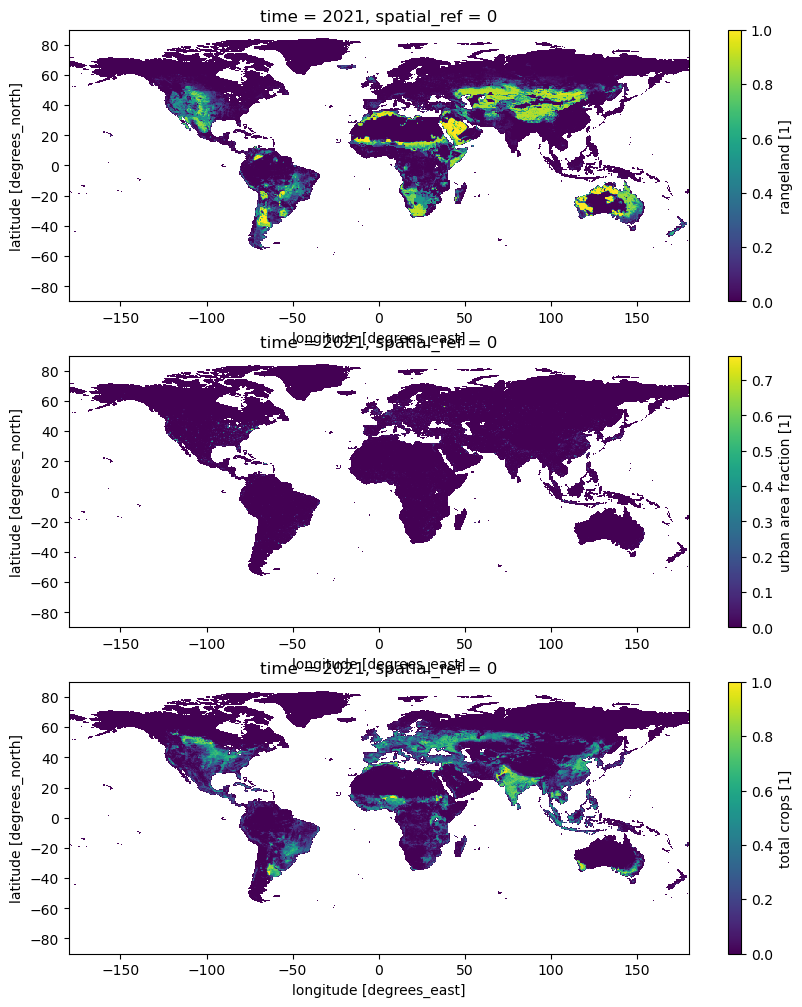

In [116]:
# plot 2021

%matplotlib inline
plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
pasture.sel(time=2021).rangeland.plot.imshow(cmap='viridis', add_colorbar=True)
plt.subplot(3,1,2)
urban.sel(time=2021).urbanareas.plot.imshow(cmap='viridis', add_colorbar=True)
plt.subplot(3,1,3)
crop.sel(time=2021).cropland_total.plot.imshow(cmap='viridis', add_colorbar=True)

here :  0.002652923110872507


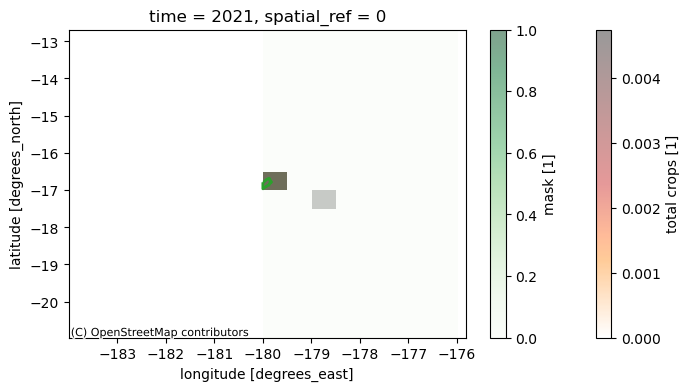

In [133]:
idx = 1888

# load test geometry
geo = gaa2.iloc[[374]]

# get the fractional cropland cover for the window of the geometry
margin = 4
xmin, ymin, xmax, ymax = geo.bounds.values[0]
xmin -= margin
ymin -= margin
xmax += margin
ymax += margin

crop21 = crop.sel(time=2021).cropland_total
dat_window = crop21.sel(lon = slice(xmin, xmax), lat = slice(ymax, ymin))

# Rasterize the polygon according to window
poly = geo['geometry'].iloc[0]
poly_mask = rasterize([(poly)],
                transform=dat_window.rio.transform(),
                out_shape=dat_window.shape, 
                all_touched=True)


# calculate the percentage of range size covered by crops
## weight data cells by grid cell size
from numpy import pi, cos

dat_window = dat_window.fillna(0)
lats = np.expand_dims(dat_window.lat,axis=1) / 360 * 2 * pi
cell_coefs = cos(lats)
dat_wheighted = dat_window.values * cell_coefs

## perform calculation
cropcover_percentage = np.sum(poly_mask * dat_wheighted) / np.sum(poly_mask * cell_coefs)

print('here : ', cropcover_percentage)
# print('script: ', script_test.cropland_2021.iloc[idx])



# Visualize
## copy array to xarray with appropiate coordinates and crs (improvised version)
mask2 = dat_window.copy()
mask2.attrs['long_name'] = 'mask'
mask2.values = poly_mask

## plot
fig, ax = plt.subplots(figsize=(8,4))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
geo.plot(ax=ax, facecolor='none', edgecolor='tab:green', linewidth=2)
ctx.add_basemap(ax=ax, crs=geo.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
dat_window.plot.imshow(ax=ax, alpha = 0.4, cmap='gist_heat_r')
mask2.plot.imshow(ax=ax, alpha= 0.5, cmap='Greens')

In [134]:
poly_mask

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)